<a href="https://colab.research.google.com/github/melody-gold/csci303_project/blob/main/CSCI303_Semester_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Filter warnings
import warnings
warnings.filterwarnings("ignore", category=Warning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import libraries
import folium
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

from IPython.display import display
from scipy.stats import mode
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
# Function to read data from host location on GitHub
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()
    return pd.read_csv(io.StringIO(response.text))

# Read the data and add some error handling for file not found
df = load_csv_from_url("https://raw.githubusercontent.com/Dr-Queue/CSCI303_DATA/refs/heads/main/SCHOOL_DATA.csv")

# Keep only high school data
df = df[df['school_level'] == 'High']

# Keep only some columns
df = df[['enrollment', 'school_name', 'city_location', 'latitude', 'longitude', 'urban_centric_locale',
        'sch_internet_wifi', 'students_SAT_ACT', 'enrl_biology', 'students_susp_in_sch', 'students_susp_out_sch_single', 'students_susp_out_sch_multiple', 'days_suspended',
        'suspensions_instances', 'teachers_fte_crdc', 'teachers_certified_fte', 'teachers_absent_fte', 'instructional_aides_fte', 'counselors_fte',
        'support_fte', 'social_workers_fte', 'administration_fte', 'psychologists_fte', 'nurses_fte', 'law_enforcement_fte', 'security_guard_fte',
        'salaries_teachers', 'salaries_total', 'salaries_instruc_staff', 'salaries_instructional_aides', 'salaries_support', 'salaries_administration',
        'expenditures_nonpersonnel',  'title_i_eligible']]

# Read in the graduation rate data
df_grad = load_csv_from_url("https://raw.githubusercontent.com/Dr-Queue/CSCI303_DATA/refs/heads/main/GRAD_DATA.csv")

# Merge the datasets based on school name
df = df.merge(df_grad[['School Name', '2021 grad rate']],
              left_on='school_name',
              right_on='School Name',
              how='left')

# Drop rows that don't have graduation data or where grad data is '-'
df = df.dropna(subset=['2021 grad rate'])
df = df[df['2021 grad rate'] != '-']

# Rename column to grad_rate and drop the school names
df = df.rename(columns={'2021 grad rate': 'grad_rate'}).drop(columns=['School Name', 'school_name'])

print(df.shape)
# df.info()

(378, 34)


In [3]:
# Data cleaning

# Drop rows with multiple missing values (more than 3)
df_cleaned = df.dropna(thresh=len(df.columns) - 3)

# Remap "Yes" and "No" to 1 and 0
df_cleaned['title_i_eligible'] = df_cleaned['title_i_eligible'].map({'Yes': 1, 'No': 0})
df_cleaned['sch_internet_wifi'] = df_cleaned['sch_internet_wifi'].map({'Yes': 1, 'No': 0})

# Encode urban_centric_locale using one hot encoding
# Grouping into city, suburb, town, and rural to prevent adding lots of new columns
group_mapping = {
    'City, large': 'City',
    'City, midsize': 'City',
    'City, small': 'City',
    'Suburb, large': 'Suburb',
    'Suburb, midsize': 'Suburb',
    'Suburb, small': 'Suburb',
    'Town, remote': 'Town',
    'Town, distant': 'Town',
    'Town, fringe': 'Town',
    'Rural, fringe': 'Rural',
    'Rural, remote': 'Rural',
    'Rural, distant': 'Rural'
}
df_cleaned['locale_group'] = df_cleaned['urban_centric_locale'].map(group_mapping)
df_cleaned = pd.get_dummies(df_cleaned, columns=['locale_group'], prefix='locale')
df_cleaned = df_cleaned.drop(columns=['urban_centric_locale'])

# Convert numeric data stored as strings to floats
df_cleaned[['enrollment', 'salaries_teachers', 'salaries_instruc_staff', 'students_susp_in_sch', 'students_susp_out_sch_single', 'students_susp_out_sch_multiple', 'grad_rate']] = df_cleaned[['enrollment', 'salaries_teachers', 'salaries_instruc_staff', 'students_susp_in_sch', 'students_susp_out_sch_single', 'students_susp_out_sch_multiple','grad_rate']].apply(pd.to_numeric, errors='coerce')

# Fill missing values with median - can refine this later, other fill methods may make more sense
num_cols = df_cleaned.columns.difference(['city_location', 'latitude', 'longitude'])
df_cleaned[num_cols] = df_cleaned[num_cols].fillna(df_cleaned[num_cols].median())
# df_cleaned.info()

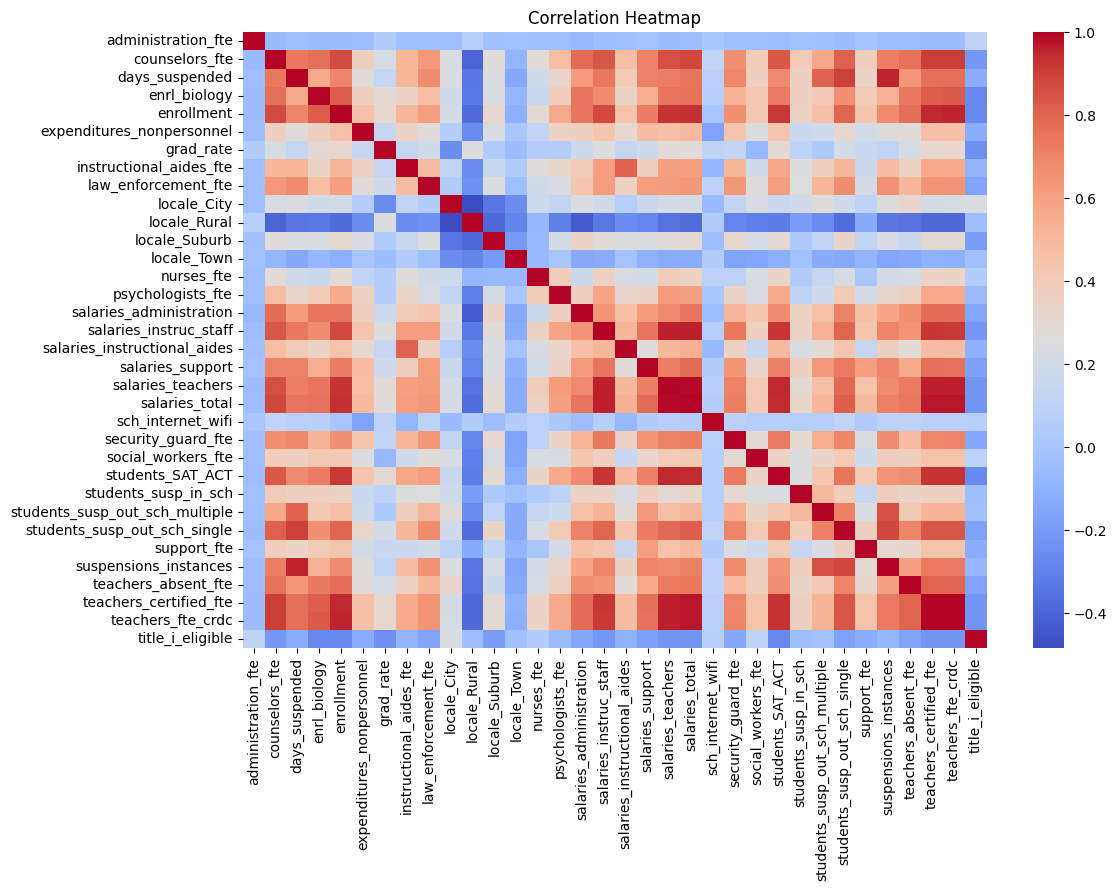

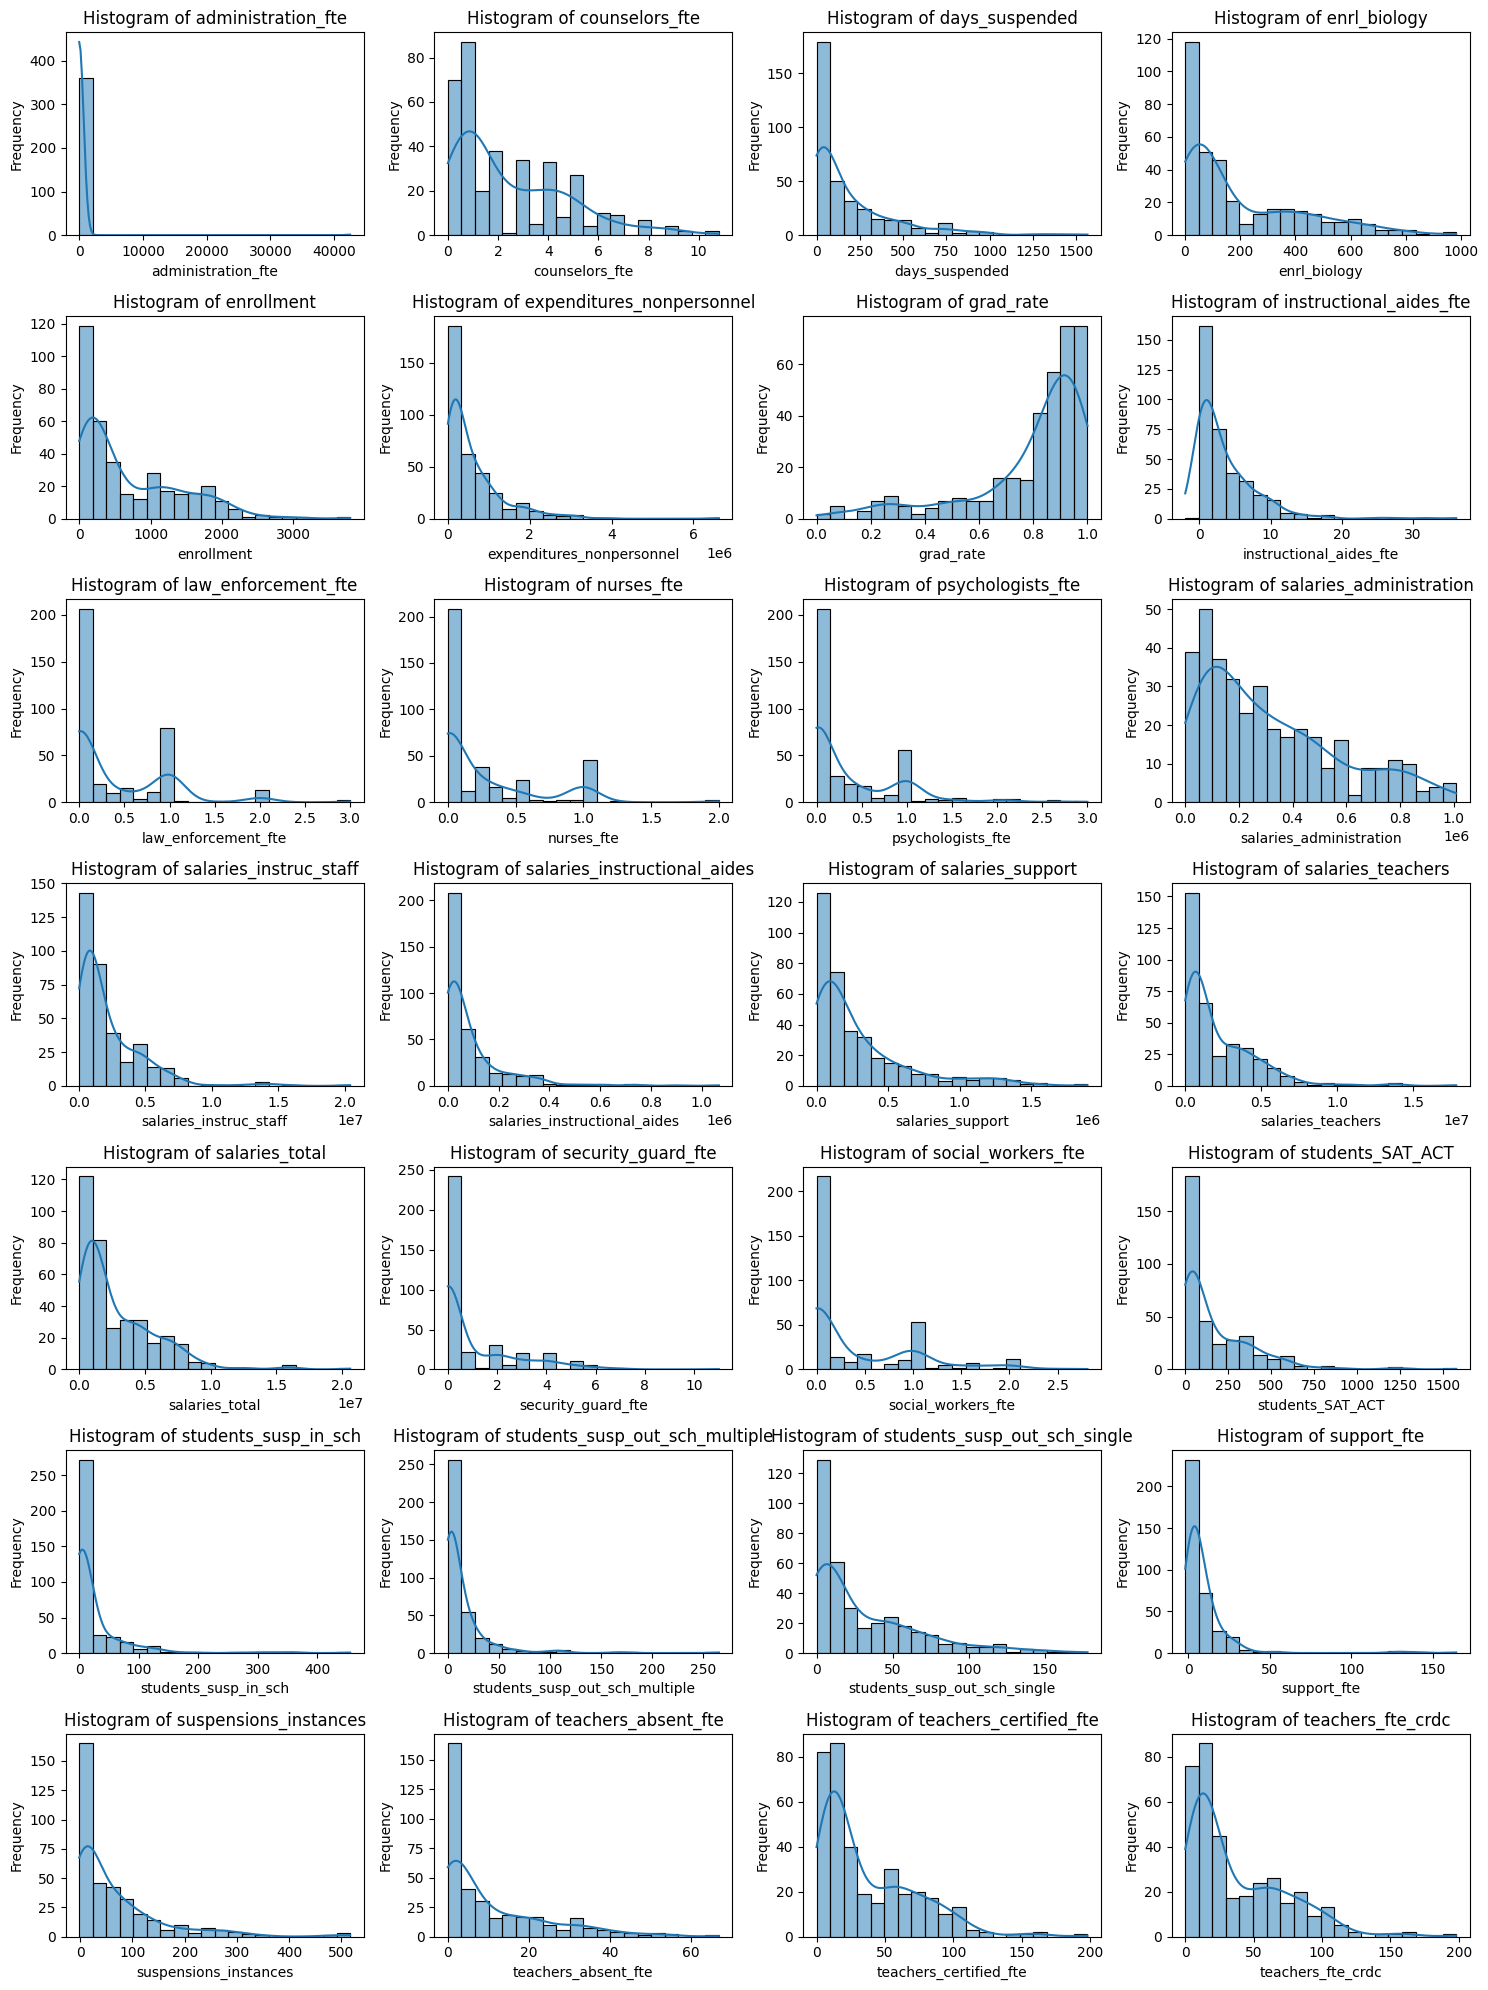

Dataset statistics:



,administration_fte,counselors_fte,days_suspended,enrl_biology,enrollment,expenditures_nonpersonnel,grad_rate,instructional_aides_fte,law_enforcement_fte,nurses_fte,psychologists_fte,salaries_administration,salaries_instruc_staff,salaries_instructional_aides,salaries_support,salaries_teachers,salaries_total,sch_internet_wifi,security_guard_fte,social_workers_fte,students_SAT_ACT,students_susp_in_sch,students_susp_out_sch_multiple,students_susp_out_sch_single,support_fte,suspensions_instances,teachers_absent_fte,teachers_certified_fte,teachers_fte_crdc,title_i_eligible
count,361.000000,361.000000,361.000000,361.000000,361.000000,3.610000e+02,361.000000,361.000000,361.000000,361.000000,361.000000,3.610000e+02,3.610000e+02,3.610000e+02,3.610000e+02,3.610000e+02,3.610000e+02,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000
mean,122.227147,2.489418,187.770083,201.119114,700.858726,5.940978e+05,0.791725,3.608587,0.385512,0.249391,0.350499,3.166085e+05,2.224947e+06,8.902647e+04,2.936160e+05,2.194859e+06,2.914967e+06,0.983380,0.968061,0.399695,177.196676,25.217452,13.429363,30.952909,9.219224,64.969529,10.592078,37.423961,38.163435,0.218837
std,2236.608500,2.280215,256.061407,218.454279,703.369943,7.394952e+05,0.222961,4.602581,0.557807,0.384392,0.533247,2.553652e+05,2.575463e+06,1.365926e+05,3.449982e+05,2.446086e+06,2.960961e+06,0.128022,1.672235,0.598162,220.266386,53.375014,25.986131,35.663481,17.666998,87.432238,13.051166,34.500427,34.905561,0.414031
min,-2.000000,0.000000,-2.000000,1.000000,0.000000,-2.000000e+00,0.000000,-2.000000,0.000000,0.000000,0.000000,-2.000000e+00,1.403500e+04,-2.000000e+00,-2.000000e+00,4.450000e+03,-2.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.000000,-2.000000,0.000000,0.000000,0.000000,0.000000
25%,1.500000,1.000000,16.000000,35.000000,132.000000,1.220140e+05,0.734400,0.530000,0.000000,0.000000,0.000000,1.053803e+05,5.183620e+05,9.049000e+03,5.906776e+04,5.013770e+05,7.364320e+05,1.000000,0.000000,0.000000,28.000000,0.000000,1.000000,4.000000,1.840000,7.000000,1.000000,10.760000,11.000000,0.000000
50%,3.180000,1.900000,78.000000,100.000000,387.000000,3.018480e+05,0.878600,2.000000,0.000000,0.000000,0.000000,2.518635e+05,1.266092e+06,3.896000e+04,1.655301e+05,1.171892e+06,1.717632e+06,1.000000,0.000000,0.000000,77.000000,5.500000,4.000000,16.000000,4.750000,27.000000,5.000000,22.000000,23.000000,0.000000
75%,6.000000,4.000000,269.000000,336.000000,1180.000000,8.256390e+05,0.938000,5.250000,1.000000,0.340000,0.600000,4.636382e+05,3.010161e+06,1.089916e+05,3.888888e+05,3.422650e+06,4.433559e+06,1.000000,2.000000,0.920000,283.000000,22.000000,15.000000,48.000000,11.000000,87.000000,17.200000,58.500000,62.000000,0.000000
max,42500.000000,10.800000,1566.000000,982.000000,3797.000000,6.618479e+06,1.000000,36.080000,3.000000,2.000000,3.000000,1.009812e+06,2.040226e+07,1.068014e+06,1.892603e+06,1.781038e+07,2.062155e+07,1.000000,11.000000,2.810000,1575.000000,455.000000,265.000000,178.000000,164.470000,517.000000,67.000000,198.200000,198.000000,1.000000


In [4]:
# Data visualization and exploration

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_cleaned[num_cols].corr(), annot=False, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Numerical columns to plot - doesn't make sense to plot binary features
num_cols_plt = df_cleaned.columns.difference(['city_location', 'latitude','longitude', 'locale_City', 'locale_Rural',
                                              'locale_Suburb', 'locale_Town', 'sch_internet_wifi', 'title_i_eligible'])
# Plotting histograms of numerical values
plt.figure(figsize=(15, 20))
for i, col in enumerate(df_cleaned[num_cols_plt]):
    plt.subplot(7, 4, i + 1)
    sns.histplot(df_cleaned[col], bins=20, kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Dataset descriptive statistics
print("Dataset statistics:\n")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_cleaned[num_cols].describe())

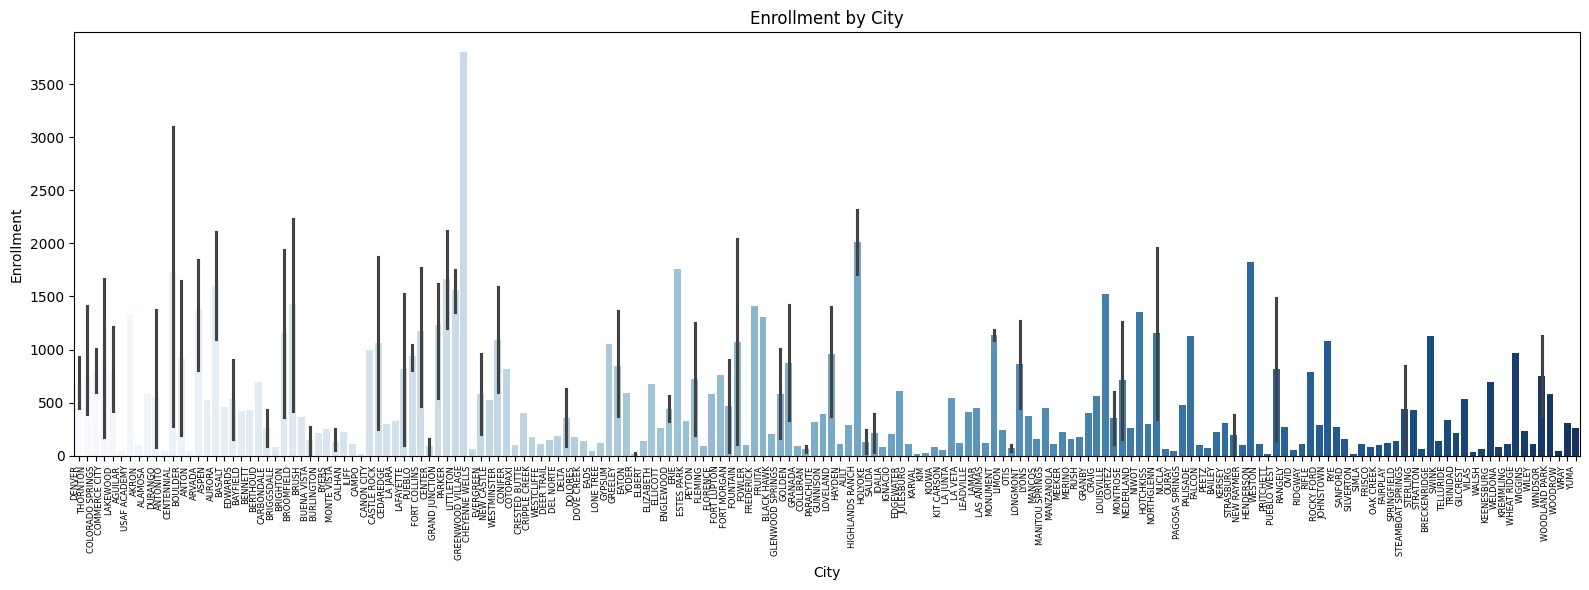

In [5]:
# Create the bar chart
plt.figure(figsize=(16, 6))
sns.barplot(x='city_location', y='enrollment', data=df_cleaned, palette='Blues')
plt.title('Enrollment by City')
plt.xlabel('City')
plt.ylabel('Enrollment')
plt.xticks(rotation=90, ha='right', fontsize=6)
plt.tight_layout()
plt.show()

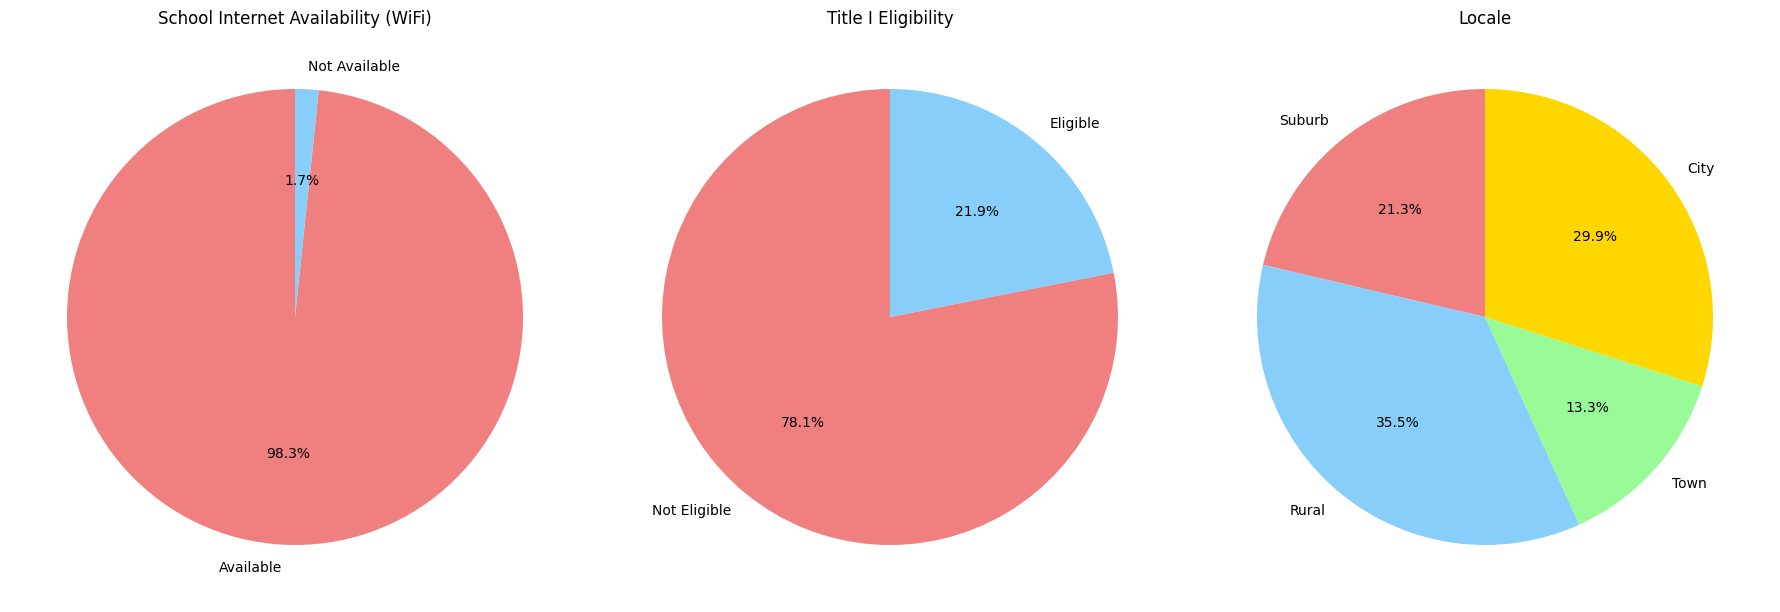

In [6]:
# Create pie charts for categorical features
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Pie chart for 'sch_internet_wifi'
wifi_counts = df_cleaned['sch_internet_wifi'].value_counts()
axes[0].pie(wifi_counts, labels=['Available', 'Not Available'], autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightskyblue'])
axes[0].set_title('School Internet Availability (WiFi)')

# Pie chart for 'title_i_eligible'
title_i_counts = df_cleaned['title_i_eligible'].value_counts()
axes[1].pie(title_i_counts, labels=['Not Eligible', 'Eligible'], autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightskyblue'])
axes[1].set_title('Title I Eligibility')

# Pie chart for locale (Suburb, Rural, Town, City)
# Sum each of these columns to get the overall distribution of locales
locale_counts = [
    df_cleaned['locale_Suburb'].sum(),
    df_cleaned['locale_Rural'].sum(),
    df_cleaned['locale_Town'].sum(),
    df_cleaned['locale_City'].sum()
]
locale_labels = ['Suburb', 'Rural', 'Town', 'City']
axes[2].pie(locale_counts, labels=locale_labels, autopct='%1.1f%%', startangle=90, colors = ['lightcoral', 'lightskyblue', 'palegreen', 'gold'])
axes[2].set_title('Locale')

# Display all charts
plt.tight_layout()
plt.show()

In [7]:
# Target data is grad_rate
y = df_cleaned['grad_rate']

# Remove target and plotting data from features
X = df_cleaned.drop(columns=['grad_rate', 'city_location', 'latitude', 'longitude'])

#Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


#Data splitting (train, test)
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)